In [1]:
"""
ML Baseline Pipeline for NLI using TF-IDF
Trains traditional ML models: Logistic Regression, SVC, Random Forest, XGBoost
"""

import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

d:\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

ARTIFACTS_DIR = './artifacts/ml_baseline'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

LOG_FILE = os.path.join(ARTIFACTS_DIR, 'ml_baseline_log.txt')
RESULTS_FILE = os.path.join(ARTIFACTS_DIR, 'results.json')
MODELS_DIR = os.path.join(ARTIFACTS_DIR, 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

LABEL_NAMES = ['ENTAILMENT', 'NEUTRAL', 'CONTRADICTION']

In [3]:
# TF-IDF Configuration
TFIDF_MAX_FEATURES = 15000
TFIDF_NGRAM_RANGE = (1, 2)

def log(msg):
    """Log to file and console"""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    log_msg = f"[{timestamp}] {msg}"
    print(log_msg)
    with open(LOG_FILE, 'a') as f:
        f.write(log_msg + '\n')


In [4]:
# ============================================================================
# DATA LOADING
# ============================================================================

def load_data():
    """Load ANLI R2 dataset"""
    log("="*70)
    log("LOADING ANLI DATASET")
    log("="*70)
    
    ds = load_dataset("facebook/anli")
    
    train = ds['train_r2']
    dev = ds['dev_r2']
    test = ds['test_r2']
    
    log(f"Train: {len(train)} examples")
    log(f"Dev: {len(dev)} examples")
    log(f"Test: {len(test)} examples")
    
    # Convert to DataFrames
    def to_df(dataset):
        return pd.DataFrame({
            'premise': [p.lower().strip() for p in dataset['premise']],
            'hypothesis': [h.lower().strip() for h in dataset['hypothesis']],
            'label': dataset['label']
        })
    
    train_df = to_df(train)
    dev_df = to_df(dev)
    test_df = to_df(test)
    
    # Combine premise and hypothesis for TF-IDF
    train_df['text'] = train_df['premise'] + ' ' + train_df['hypothesis']
    dev_df['text'] = dev_df['premise'] + ' ' + dev_df['hypothesis']
    test_df['text'] = test_df['premise'] + ' ' + test_df['hypothesis']
    
    log(f"\nLabel distribution (train):")
    for label, count in train_df['label'].value_counts().sort_index().items():
        log(f"  {LABEL_NAMES[label]}: {count} ({count/len(train_df)*100:.2f}%)")
    
    return train_df, dev_df, test_df

In [5]:
# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

def extract_tfidf_features(train_df, dev_df, test_df):
    """Extract TF-IDF features"""
    log("\n" + "="*70)
    log("EXTRACTING TF-IDF FEATURES")
    log("="*70)
    
    log(f"Max features: {TFIDF_MAX_FEATURES}")
    log(f"N-gram range: {TFIDF_NGRAM_RANGE}")
    
    # Initialize vectorizer
    vectorizer = TfidfVectorizer(
        max_features=TFIDF_MAX_FEATURES,
        ngram_range=TFIDF_NGRAM_RANGE,
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )
    
    # Fit on training data
    X_train = vectorizer.fit_transform(train_df['text'])
    X_dev = vectorizer.transform(dev_df['text'])
    X_test = vectorizer.transform(test_df['text'])
    
    y_train = train_df['label'].values
    y_dev = dev_df['label'].values
    y_test = test_df['label'].values
    
    log(f"\nFeature matrix shapes:")
    log(f"  Train: {X_train.shape}")
    log(f"  Dev: {X_dev.shape}")
    log(f"  Test: {X_test.shape}")
    
    # Save vectorizer
    vectorizer_path = os.path.join(MODELS_DIR, 'tfidf_vectorizer.pkl')
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(vectorizer, f)
    log(f"\nTF-IDF vectorizer saved to: {vectorizer_path}")
    
    return X_train, X_dev, X_test, y_train, y_dev, y_test, vectorizer

In [6]:
# ============================================================================
# MODEL TRAINING
# ============================================================================

def train_and_evaluate_model(name, model, X_train, X_dev, X_test, y_train, y_dev, y_test):
    """Train and evaluate a single model"""
    log("\n" + "-"*70)
    log(f"TRAINING: {name}")
    log("-"*70)
    
    # Train
    log(f"Fitting {name}...")
    model.fit(X_train, y_train)
    
    # Predict on all sets
    train_preds = model.predict(X_train)
    dev_preds = model.predict(X_dev)
    test_preds = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'model': name,
        'train': {
            'accuracy': float(accuracy_score(y_train, train_preds)),
            'f1_macro': float(f1_score(y_train, train_preds, average='macro'))
        },
        'dev': {
            'accuracy': float(accuracy_score(y_dev, dev_preds)),
            'f1_macro': float(f1_score(y_dev, dev_preds, average='macro'))
        },
        'test': {
            'accuracy': float(accuracy_score(y_test, test_preds)),
            'f1_macro': float(f1_score(y_test, test_preds, average='macro'))
        }
    }
    
    log(f"\nResults for {name}:")
    log(f"  Train - Acc: {results['train']['accuracy']:.4f}, F1: {results['train']['f1_macro']:.4f}")
    log(f"  Dev   - Acc: {results['dev']['accuracy']:.4f}, F1: {results['dev']['f1_macro']:.4f}")
    log(f"  Test  - Acc: {results['test']['accuracy']:.4f}, F1: {results['test']['f1_macro']:.4f}")
    
    # Classification report (test set)
    log(f"\nClassification Report ({name}):")
    report = classification_report(y_test, test_preds, target_names=LABEL_NAMES, digits=4)
    log(report)
    
    # Confusion matrix (test set)
    cm = confusion_matrix(y_test, test_preds)
    log(f"\nConfusion Matrix ({name}):")
    log(str(cm))
    
    # Save model
    model_path = os.path.join(MODELS_DIR, f'{name.lower().replace(" ", "_")}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    log(f"Model saved to: {model_path}")
    
    return results, cm, test_preds


In [7]:
# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_comparison(all_results):
    """Plot comparison of all models"""
    log("\n" + "="*70)
    log("GENERATING COMPARISON PLOTS")
    log("="*70)
    
    # Extract metrics
    models = [r['model'] for r in all_results]
    test_acc = [r['test']['accuracy'] for r in all_results]
    test_f1 = [r['test']['f1_macro'] for r in all_results]
    
    # Accuracy comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.bar(models, test_acc, color='steelblue', edgecolor='black')
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Test Accuracy Comparison', fontsize=14)
    ax1.set_ylim([0, 1])
    ax1.axhline(y=0.337, color='red', linestyle='--', label='Baseline (0.337)')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Rotate x labels
    ax1.set_xticklabels(models, rotation=45, ha='right')
    
    # F1 comparison
    ax2.bar(models, test_f1, color='coral', edgecolor='black')
    ax2.set_ylabel('F1 Score (Macro)', fontsize=12)
    ax2.set_title('Test F1 Score Comparison', fontsize=14)
    ax2.set_ylim([0, 1])
    ax2.axhline(y=0.242, color='red', linestyle='--', label='Baseline (0.242)')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # Rotate x labels
    ax2.set_xticklabels(models, rotation=45, ha='right')
    
    plt.tight_layout()
    plot_path = os.path.join(ARTIFACTS_DIR, 'model_comparison.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    log(f"Comparison plot saved to: {plot_path}")

def plot_confusion_matrices(all_cms, model_names):
    """Plot confusion matrices for all models"""
    n_models = len(all_cms)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, (cm, name) in enumerate(zip(all_cms, model_names)):
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=LABEL_NAMES,
            yticklabels=LABEL_NAMES,
            ax=axes[idx],
            cbar_kws={'label': 'Count'}
        )
        axes[idx].set_title(f'{name}', fontsize=12)
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    cm_path = os.path.join(ARTIFACTS_DIR, 'confusion_matrices.png')
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    log(f"Confusion matrices saved to: {cm_path}")

In [8]:
# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """Main ML baseline pipeline"""
    
    start_time = datetime.now()
    log("="*70)
    log("ML BASELINE PIPELINE FOR NLI")
    log("="*70)
    log(f"Started: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Load data
    train_df, dev_df, test_df = load_data()
    
    # Extract TF-IDF features
    X_train, X_dev, X_test, y_train, y_dev, y_test, vectorizer = extract_tfidf_features(
        train_df, dev_df, test_df
    )
    
    # ========================================================================
    # TRAIN ALL MODELS
    # ========================================================================
    
    log("\n" + "="*70)
    log("TRAINING ML MODELS")
    log("="*70)
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42,
            n_jobs=-1,
            verbose=0
        ),
        # 'SVC': SVC(
        #     kernel='rbf',
        #     C=1.0,
        #     random_state=42,
        #     verbose=False
        # ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            random_state=42,
            n_jobs=-1,
            verbose=0
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
    }
    
    all_results = []
    all_cms = []
    all_predictions = {}
    
    # Train and evaluate each model
    for model_name, model in models.items():
        results, cm, test_preds = train_and_evaluate_model(
            model_name, model,
            X_train, X_dev, X_test,
            y_train, y_dev, y_test
        )
        all_results.append(results)
        all_cms.append(cm)
        all_predictions[model_name] = test_preds.tolist()
    
    # ========================================================================
    # COMPARISON & VISUALIZATION
    # ========================================================================
    
    plot_comparison(all_results)
    plot_confusion_matrices(all_cms, list(models.keys()))
    
    # ========================================================================
    # FIND BEST MODEL
    # ========================================================================
    
    log("\n" + "="*70)
    log("MODEL COMPARISON")
    log("="*70)
    
    # Sort by test F1
    sorted_results = sorted(all_results, key=lambda x: x['test']['f1_macro'], reverse=True)
    
    log("\nRanking by Test F1 Score:")
    for i, result in enumerate(sorted_results, 1):
        log(f"{i}. {result['model']}: {result['test']['f1_macro']:.4f} "
            f"(Acc: {result['test']['accuracy']:.4f})")
    
    best_model = sorted_results[0]
    log(f"\nBest Model: {best_model['model']}")
    log(f"  Test Accuracy: {best_model['test']['accuracy']:.4f}")
    log(f"  Test F1: {best_model['test']['f1_macro']:.4f}")
    
    # ========================================================================
    # BASELINE COMPARISON
    # ========================================================================
    
    log("\n" + "="*70)
    log("BASELINE COMPARISON")
    log("="*70)
    
    BASELINE_ACC = 0.337
    BASELINE_F1 = 0.242
    
    comparison = []
    for result in all_results:
        acc_improvement = result['test']['accuracy'] - BASELINE_ACC
        f1_improvement = result['test']['f1_macro'] - BASELINE_F1
        
        beats_baseline = (result['test']['accuracy'] > BASELINE_ACC and 
                         result['test']['f1_macro'] > BASELINE_F1)
        
        comp = {
            'model': result['model'],
            'test_accuracy': result['test']['accuracy'],
            'test_f1': result['test']['f1_macro'],
            'accuracy_improvement': acc_improvement,
            'f1_improvement': f1_improvement,
            'beats_baseline': beats_baseline
        }
        comparison.append(comp)
        
        status = "BEATS" if beats_baseline else "BELOW"
        log(f"\n{result['model']}:")
        log(f"  Accuracy: {result['test']['accuracy']:.4f} ({acc_improvement:+.4f}) - {status} baseline")
        log(f"  F1 Score: {result['test']['f1_macro']:.4f} ({f1_improvement:+.4f}) - {status} baseline")
    
    # ========================================================================
    # SAVE RESULTS
    # ========================================================================
    
    log("\n" + "="*70)
    log("SAVING RESULTS")
    log("="*70)
    
    final_results = {
        'timestamp': start_time.strftime('%Y-%m-%d %H:%M:%S'),
        'tfidf_config': {
            'max_features': TFIDF_MAX_FEATURES,
            'ngram_range': TFIDF_NGRAM_RANGE
        },
        'baseline_metrics': {
            'accuracy': BASELINE_ACC,
            'f1_macro': BASELINE_F1
        },
        'model_results': all_results,
        'baseline_comparison': comparison,
        'best_model': {
            'name': best_model['model'],
            'test_accuracy': best_model['test']['accuracy'],
            'test_f1': best_model['test']['f1_macro']
        },
        'predictions': all_predictions
    }
    
    with open(RESULTS_FILE, 'w') as f:
        json.dump(final_results, f, indent=2)
    
    log(f"Results saved to: {RESULTS_FILE}")
    
    # ========================================================================
    # SUMMARY
    # ========================================================================
    
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    
    log("\n" + "="*70)
    log("PIPELINE SUMMARY")
    log("="*70)
    
    log(f"\nTotal duration: {int(duration//60)}m {int(duration%60)}s")
    log(f"\nBest performing model: {best_model['model']}")
    log(f"  Test Accuracy: {best_model['test']['accuracy']:.4f}")
    log(f"  Test F1 Score: {best_model['test']['f1_macro']:.4f}")
    
    # Count models beating baseline
    beating_baseline = sum(1 for c in comparison if c['beats_baseline'])
    log(f"\nModels beating baseline: {beating_baseline}/{len(comparison)}")
    
    log(f"\nAll artifacts saved to: {ARTIFACTS_DIR}")
    
    # ========================================================================
    # FINAL STATUS
    # ========================================================================
    
    log("\n" + "="*70)
    if beating_baseline > 0:
        log("ML BASELINE PIPELINE COMPLETED SUCCESSFULLY")
        log(f"{beating_baseline} model(s) beat the baseline")
    else:
        log("ML BASELINE PIPELINE COMPLETED")
        log("WARNING: No models beat the baseline")
    log("="*70)
    
    return final_results


Starting ML Baseline Pipeline

Models to train:
  1. Logistic Regression
  2. Support Vector Classifier (SVC)
  3. Random Forest
  4. XGBoost


[2025-11-08 11:37:14] ======================================================================
[2025-11-08 11:37:14] ML BASELINE PIPELINE FOR NLI
[2025-11-08 11:37:14] ======================================================================
[2025-11-08 11:37:14] Started: 2025-11-08 11:37:14
[2025-11-08 11:37:14] ======================================================================
[2025-11-08 11:37:14] LOADING ANLI DATASET
[2025-11-08 11:37:14] ======================================================================
[2025-11-08 11:37:15] Train: 45460 examples
[2025-11-08 11:37:16] Dev: 1000 examples
[2025-11-08 11:37:16] Test: 1000 examples
[2025-11-08 11:37:19] 
Label distribution (train):
[2025-11-08 11:37:19]   ENTAILMENT: 14448 (31.78%)
[2025-11-08 11:37:19]   NEUTRAL: 20959 (46.10%)
[2025-11-08 11:37:19]   CONTRADICTION: 10053 (22.11%)
[2025-1

C:\Users\jayja\AppData\Local\Temp\ipykernel_8004\52145701.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models, rotation=45, ha='right')
C:\Users\jayja\AppData\Local\Temp\ipykernel_8004\52145701.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models, rotation=45, ha='right')


[2025-11-08 11:39:42] Comparison plot saved to: ./artifacts/ml_baseline\model_comparison.png


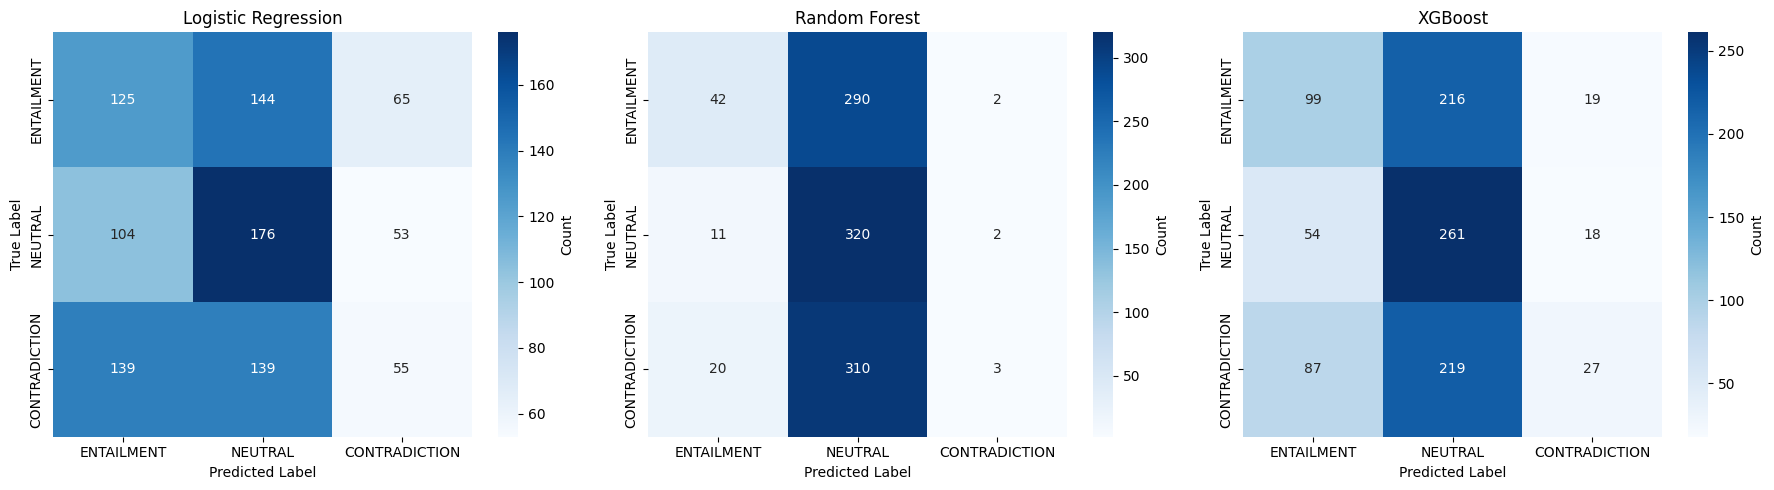

[2025-11-08 11:39:43] Confusion matrices saved to: ./artifacts/ml_baseline\confusion_matrices.png
[2025-11-08 11:39:43] 
[2025-11-08 11:39:43] MODEL COMPARISON
[2025-11-08 11:39:43] ======================================================================
[2025-11-08 11:39:43] 
Ranking by Test F1 Score:
[2025-11-08 11:39:43] 1. Logistic Regression: 0.3393 (Acc: 0.3560)
[2025-11-08 11:39:43] 2. XGBoost: 0.3294 (Acc: 0.3870)
[2025-11-08 11:39:43] 3. Random Forest: 0.2449 (Acc: 0.3650)
[2025-11-08 11:39:43] 
Best Model: Logistic Regression
[2025-11-08 11:39:43]   Test Accuracy: 0.3560
[2025-11-08 11:39:43]   Test F1: 0.3393
[2025-11-08 11:39:43] 
[2025-11-08 11:39:43] BASELINE COMPARISON
[2025-11-08 11:39:43] ======================================================================
[2025-11-08 11:39:43] 
Logistic Regression:
[2025-11-08 11:39:43]   Accuracy: 0.3560 (+0.0190) - BEATS baseline
[2025-11-08 11:39:43]   F1 Score: 0.3393 (+0.0973) - BEATS baseline
[2025-11-08 11:39:43] 
Random Forest

In [9]:
try:
    print("\n" + "="*70)
    print("Starting ML Baseline Pipeline")
    print("="*70)
    print("\nModels to train:")
    print("  1. Logistic Regression")
    print("  2. Support Vector Classifier (SVC)")
    print("  3. Random Forest")
    print("  4. XGBoost")
    print("\n")
    
    results = main()
    
    print("\n" + "="*70)
    print("PIPELINE COMPLETED")
    print("="*70)
    print(f"\nBest Model: {results['best_model']['name']}")
    print(f"Test Accuracy: {results['best_model']['test_accuracy']:.4f}")
    print(f"Test F1 Score: {results['best_model']['test_f1']:.4f}")
    
    # Check if any model beats baseline
    beating = sum(1 for c in results['baseline_comparison'] if c['beats_baseline'])
    if beating > 0:
        print(f"\n{beating} model(s) beat the baseline!")
    else:
        print("\nNo models beat baseline - consider feature engineering")
    
    print(f"\nResults saved to: {ARTIFACTS_DIR}")
    
except Exception as e:
    print(f"\nPipeline failed: {str(e)}")
    import traceback
    traceback.print_exc()
    sys.exit(1)